# Computer Vision CSCI-GA.2272-001 Assignment 2

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

In [2]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

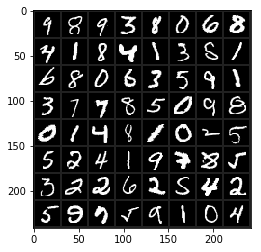

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


# Does not work for some unknown (yet to be found) reason
def imshow2(img):
    if dataset =='mnist':
        unorm = UnNormalize(mean=(0.1307,), std=(0.3081,))
    elif dataset == 'cifar10':
        unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    
    img = unorm(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    
# functions to show an image
def imshow(img):
    if dataset =='mnist':
        img = img*0.3081 + 0.1307 # unnormalize
    elif dataset == 'cifar10':
        img = img / 2 + 0.5     # unnormalize
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.


(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )


In [5]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [6]:
def train(epoch):
    network.train()
    loss_collect = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # wrap inputs in Variable
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        loss_collect.append(loss.data[0])

        # print statistics
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    
    return loss_collect

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data.cuda(), volatile=True), Variable(target.cuda())
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [7]:
loss_g = []
for epoch in range(1, 1 + epochs):
    loss_g.extend(train(epoch))
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.432553
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.830794
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.524474
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.263197
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.561578
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.516961
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.279667
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.286319
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.241411
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.233533

Test set: Average loss: 0.3306, Accuracy: 9089/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.436318
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.494924
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.476951
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.452447
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.411289
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.194206
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.402748
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.380579
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.403462
T

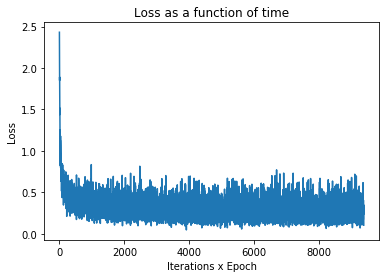

In [8]:
plt.plot(loss_g)
plt.xlabel("Iterations x Epoch")
plt.ylabel("Loss")
plt.title("Loss as a function of time")

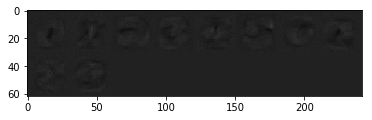

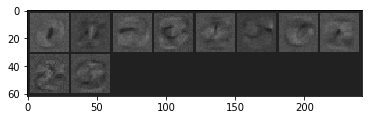

In [9]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28)))
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28),normalize=True, scale_each=True))                    

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.


In [10]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    """Samples elements sequentially, always in the same order.
    Arguments:
        data_source (Dataset): dataset to sample from
        num_samples (int): number of samples to draw
    """

    def __init__(self, data_source, num_samples):
        self.data_source = data_source
        if num_samples < len(self.data_source):
            self.num_samples = num_samples
        else:
            self.num_samples = len(self.data_source)
            
    def __iter__(self):
        return iter(range(self.num_samples))

    def __len__(self):
        return self.num_samples

In [11]:
subset_sampler = SubsetSampler(trainset, 50)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, sampler=subset_sampler, num_workers=0)
subset_sampler = SubsetSampler(testset, 50)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, sampler=subset_sampler, num_workers=0)

network = Net(num_inputs, num_outputs)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [12]:
loss_g = []
for epoch in range(1, 1 + epochs):
    loss_g.extend(train(epoch))
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.818081

Test set: Average loss: 0.0073, Accuracy: 27/10000 (0%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.596171

Test set: Average loss: 0.0058, Accuracy: 32/10000 (0%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.123463

Test set: Average loss: 0.0053, Accuracy: 34/10000 (0%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.063994

Test set: Average loss: 0.0052, Accuracy: 36/10000 (0%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.044397

Test set: Average loss: 0.0052, Accuracy: 36/10000 (0%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.036086

Test set: Average loss: 0.0051, Accuracy: 36/10000 (0%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.030964

Test set: Average loss: 0.0051, Accuracy: 36/10000 (0%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.027339

Test set: Average loss: 0.0051, Accuracy: 36/10000 (0%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.024580

Test set: Average loss: 0.0051, Accuracy: 36/10000 (0%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.022384

Test set: Average loss: 0.

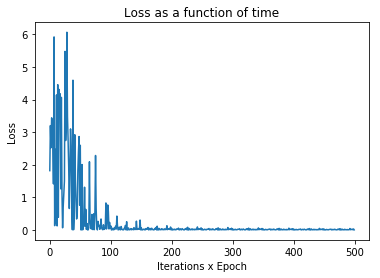

In [13]:
plt.plot(loss_g)
plt.xlabel("Iterations x Epoch")
plt.ylabel("Loss")
plt.title("Loss as a function of time")

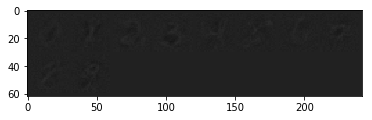

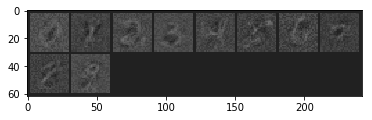

In [14]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28)))
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28),normalize=True, scale_each=True))        

### Overfit 
As we can see the loss (indicator of training error) quickly becomes very small (tending to 0) while the test error (as training accuracy tends to 0) becomes very high. These are clear indicators of overfitting the data. Since a very small amount of data was provided, the model overfits over it and lacks the ability to generalise at all which leads to very poor test accuracy. 


By definition, **overfitting is a modeling error which occurs when a function is too closely fit to a limited set of data points** which is clearly what happens in this case. Overfitting the model generally takes the form of making an overly complex model to explain idiosyncrasies in the data under study. There are many ways to fight overfitting such as the following (not an exhaustive list by any means):

* Get more data (and/or use data augmentation)
* Use regularization, like Dropout and perhaps even L1 and L2
* Feature scale clipping
* Global average pooling
* Make network smaller
* Early stopping


## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.


In [15]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

network = Net(num_inputs, num_outputs, hidden_units=1000)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [16]:
loss_g = []
for epoch in range(1, 1 + epochs):
    loss_g.extend(train(epoch))
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.344141
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.829380
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.549929
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.466398
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.401492
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.534058
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.398345
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.492511
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.323353
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.269988

Test set: Average loss: 0.3233, Accuracy: 9093/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.435899
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.262041
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.361291
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.300726
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.453793
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.260048
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.406989
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.527357
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.375693
T

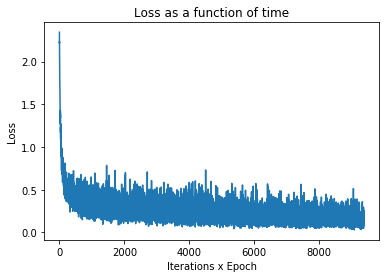

In [17]:
plt.plot(loss_g)
plt.xlabel("Iterations x Epoch")
plt.ylabel("Loss")
plt.title("Loss as a function of time")

-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

In [18]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

network = Net(num_inputs, num_outputs, hidden_units=1000)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=10)

In [19]:
loss_g = []
for epoch in range(1, 1 + epochs):
    loss_g.extend(train(epoch))
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.264647
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1552.625854
Train Epoch: 1 [12800/60000 (21%)]	Loss: 429.011383
Train Epoch: 1 [19200/60000 (32%)]	Loss: 653.251892
Train Epoch: 1 [25600/60000 (43%)]	Loss: 750.171326
Train Epoch: 1 [32000/60000 (53%)]	Loss: 303.090851
Train Epoch: 1 [38400/60000 (64%)]	Loss: 251.620911
Train Epoch: 1 [44800/60000 (75%)]	Loss: 356.836029
Train Epoch: 1 [51200/60000 (85%)]	Loss: 377.940063
Train Epoch: 1 [57600/60000 (96%)]	Loss: 365.819000

Test set: Average loss: 363.3634, Accuracy: 5395/10000 (54%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 300.932678
Train Epoch: 2 [6400/60000 (11%)]	Loss: 564.763000
Train Epoch: 2 [12800/60000 (21%)]	Loss: 241.000412
Train Epoch: 2 [19200/60000 (32%)]	Loss: 152.962906
Train Epoch: 2 [25600/60000 (43%)]	Loss: 173.837845
Train Epoch: 2 [32000/60000 (53%)]	Loss: 98.620087
Train Epoch: 2 [38400/60000 (64%)]	Loss: 228.648590
Train Epoch: 2 [44800/60000 (75%)]	Loss: 425.462982
Train Epoch: 2 

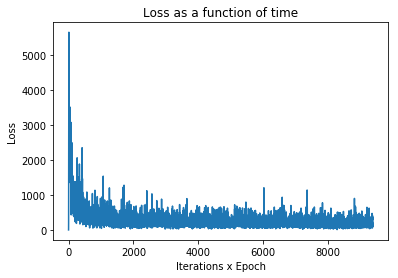

In [20]:
plt.plot(loss_g)
plt.xlabel("Iterations x Epoch")
plt.ylabel("Loss")
plt.title("Loss as a function of time")

### Overshoot

Choosing too large a value for the learning rate, makes the training process (optimisation) unstable. This is because higher learning rates will decay the loss faster, but they get stuck at worse values of loss (green line in image below) and in our case, we see that the loss flucutates and lot and gets stuck around loss values > 100, while with a lower lr we were able to see loss value as low as ~0.5. This is because there is too much "energy" in the optimization and the parameters are bouncing around chaotically, unable to settle in a nice spot in the optimization landscape.
![LR](http://cs231n.github.io/assets/nn3/learningrates.jpeg)

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

In [21]:
dataset = 'cifar10'
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.



In [22]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072


class Net(nn.Module):
    def __init__(self, num_channels, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.fc1 = nn.Linear(128 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, num_outputs)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
#         print(x.size())
        x = x.view(-1, 128 * 5 * 5)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

num_channels = iter(train_loader).next()[0].size()[1]
network = Net(num_channels, num_outputs=10)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.


In [23]:
epochs = 20

loss_g = []
for epoch in range(1, 1 + epochs):
    loss_g.extend(train(epoch))
    test()


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.311074
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.168980
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.061869
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.884514
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.868822
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.917039
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.910085
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.787620

Test set: Average loss: 1.7848, Accuracy: 18857/50000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.625484
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.762575
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.773592
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.785707
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.722296
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.567242
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.516354
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.783387

Test set: Average loss: 1.6084, Accuracy: 21455/50000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.623398
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.6


Test set: Average loss: 0.8388, Accuracy: 35285/50000 (71%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.757807
Train Epoch: 19 [6400/50000 (13%)]	Loss: 1.008512
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.783986
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.695759
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.787887
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.749146
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.921931
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.806059

Test set: Average loss: 0.8064, Accuracy: 36024/50000 (72%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.807722
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.763600
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.789367
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.804348
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.764329
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.768273
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.610842
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.660720

Test set: Average loss: 0.7875, Accuracy: 36237/50000 (72%)



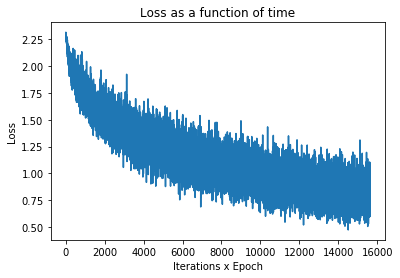

In [24]:
plt.plot(loss_g)
plt.xlabel("Iterations x Epoch")
plt.ylabel("Loss")
plt.title("Loss as a function of time")

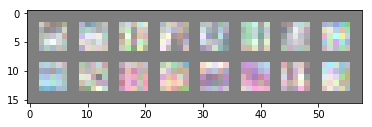

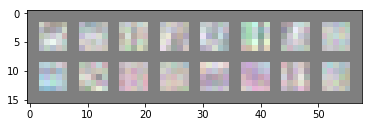

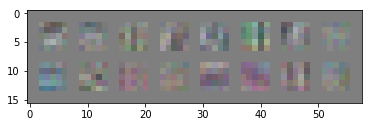

In [25]:
for x in network.modules():
    if isinstance(x, nn.Conv2d):
        imshow(utils.make_grid(x.weight.data.cpu(),normalize=True, scale_each=True))
        imshow(utils.make_grid(x.weight.data.cpu(),normalize=True))
        imshow(utils.make_grid(x.weight.data.cpu()))
        break

- Give a breakdown of the parameters within the above model, and the overall number.

Number of learnable parameters per different type of layer is as follows:

* **Input layer:** All the input layer does is read the input image, so there are no learnable parameters here.

* **Convolutional layers:** Consider a convolutional layer which takes `l` feature maps at the input, and has `k` feature maps as output. The filter size is `n x m`. For example, this will look like this:

![Visualization of a convolutional layer](https://i.stack.imgur.com/2r4XG.png)

Here, the input has `l=32` feature maps as input, `k=64` feature maps as output, and the filter size is `n=3 x m=3`. It is important to understand, that we don't simply have a `3x3` filter, but actually a `3x3x32` filter, as our input has 32 dimensions. And we learn 64 different `3x3x32` filters. Thus, the total number of weights is `n*m*k*l`. Then, there is also a bias term for each feature map, so we have a total number of parameters of `(n*m*l+1)*k`.

* Pooling layers: The pooling layers e.g. do the following: "replace a 2x2 neighborhood by its maximum value". So there is no parameter you could learn in a pooling layer.
* Fully-connected layers: In a fully-connected layer, all input units have a separate weight to each output unit. For `n` inputs and `m` outputs, the number of weights is `n*m`. Additionally, you have a bias for each output node, so you are at `(n+1)*m` parameters.
* Output layer: The output layer is a normal fully-connected layer, so `(n+1)*m` parameters, where `n` is the number of inputs and `m` is the number of outputs.

Reference: https://stackoverflow.com/questions/42786717/how-to-calculate-learnable-parameters-for-neural-network

All the different parts of the model can be seen below:

In [27]:
network

Net (
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (3200 -> 64)
  (fc2): Linear (64 -> 10)
)

The total number of learnable parameters are calculated as follows where the bias for each layer are after the respective layer. 

In [26]:
params = list(network.parameters())
print(len(params))
total_parameter_count = 0
for param in params:
    param_count = np.prod(param.size())
    total_parameter_count += param_count
    print(param.size())
print("Total number of parameters:", total_parameter_count)

8
torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([128, 16, 5, 5])
torch.Size([128])
torch.Size([64, 3200])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
Total number of parameters: 258058
